# Import

In [1]:
import math
import json
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Preprocess

In [94]:
def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
    data = {"labels": [], "mfcc": []}
    sample_rate = 22050
    samples_per_segment = int(sample_rate * 30 / num_segment)

    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath == dataset_path:
            continue

        for f in sorted(filenames):
            if not f.endswith(".wav"):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            print("Track Name: ", file_path)

            y, sr = librosa.load(file_path, sr=sample_rate)
            for n in range(num_segment):
                mfcc = librosa.feature.mfcc(y[samples_per_segment*n:samples_per_segment*(n+1)],
                                            sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T
                print(len(mfcc))
                print(math.ceil(samples_per_segment / hop_length))
                if len(mfcc) == math.ceil(samples_per_segment / hop_length):
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(label_idx-1)

    return data

In [95]:
preprocess('genres_original')

genres_original\blues 0
genres_original\classical 1
genres_original\country 2
genres_original\disco 3
genres_original\hiphop 4
genres_original\jazz 5
genres_original\metal 6
genres_original\pop 7
genres_original\reggae 8
genres_original\rock 9


In [2]:
mfcc_data = np.load('mfcc_data.npy', allow_pickle=True).item()

In [28]:
# x = np.array(mfcc_data["mfcc"])
# y = np.array(mfcc_data["labels"])

x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = tf.keras.utils.to_categorical(y, num_classes=10)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2)

In [30]:
unique, counts = np.unique(y, return_counts=True)

In [44]:
x_train.shape

(7489, 130, 40, 1)

In [39]:
counts

array([1000,  999,  999,  999,  999,  990, 1000, 1000, 1000, 1000],
      dtype=int64)

# Data Distribution

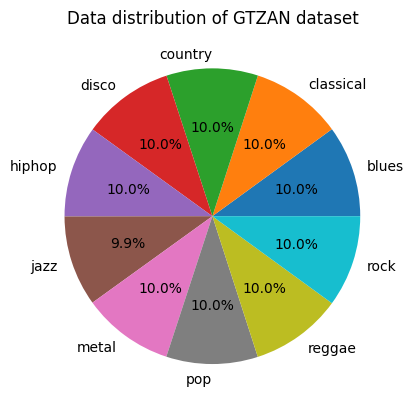

In [43]:
from matplotlib import pyplot as plt
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.pie(counts, labels=genres, autopct='%1.1f%%')
plt.title('Data distribution of GTZAN dataset')
plt.savefig('mfcc_genre_pie_chart.png', dpi=300)

In [35]:
mfcc_data = 0

# CNN Model

In [4]:
input_shape = x_train.shape[1:]
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu',padding='valid', input_shape=input_shape),
    layers.MaxPooling2D(2, padding='same'),

    layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics ='acc')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 38, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 17, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 9, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 9, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 7, 128)        1

In [5]:
history = cnn_model.fit(x_train, y_train, epochs=40, verbose=2, batch_size=32)

Epoch 1/40
235/235 - 29s - loss: 0.2480 - acc: 0.4161 - 29s/epoch - 125ms/step
Epoch 2/40
235/235 - 27s - loss: 0.1905 - acc: 0.5684 - 27s/epoch - 117ms/step
Epoch 3/40
235/235 - 27s - loss: 0.1719 - acc: 0.6208 - 27s/epoch - 115ms/step
Epoch 4/40
235/235 - 28s - loss: 0.1571 - acc: 0.6620 - 28s/epoch - 121ms/step
Epoch 5/40
235/235 - 28s - loss: 0.1410 - acc: 0.7037 - 28s/epoch - 118ms/step
Epoch 6/40
235/235 - 27s - loss: 0.1305 - acc: 0.7313 - 27s/epoch - 115ms/step
Epoch 7/40
235/235 - 28s - loss: 0.1194 - acc: 0.7554 - 28s/epoch - 118ms/step
Epoch 8/40
235/235 - 27s - loss: 0.1082 - acc: 0.7810 - 27s/epoch - 116ms/step
Epoch 9/40
235/235 - 27s - loss: 0.1020 - acc: 0.7981 - 27s/epoch - 115ms/step
Epoch 10/40
235/235 - 27s - loss: 0.0933 - acc: 0.8187 - 27s/epoch - 114ms/step
Epoch 11/40
235/235 - 26s - loss: 0.0852 - acc: 0.8378 - 26s/epoch - 113ms/step
Epoch 12/40
235/235 - 27s - loss: 0.0795 - acc: 0.8507 - 27s/epoch - 113ms/step
Epoch 13/40
235/235 - 27s - loss: 0.0715 - acc: 0

In [59]:
y_test

array([1, 2, 5, ..., 1, 3, 0], dtype=int64)

In [6]:
#Save the model
cnn_model.save('cnn_model.h5')

In [7]:
classes = []
classes_test = []
for i in range(10):
    classes.append(x_test[y_test[:,i]==1])
    classes_test.append(y_test[y_test[:,i]==1])

In [8]:
test_acc_list = []
genre_pred_list = []
for i in range(len(classes)):
    y_pred_class = cnn_model.predict(classes[i])
    y_pred_class = np.argmax(y_pred_class, axis=1)
    genre_pred_list.append(y_pred_class)
    y_test_class = np.argmax(classes_test[i], axis=1)
    test_acc_list.append(np.sum(y_pred_class == y_test_class)/len(y_test_class))
    print("Accuracy for class ", i, " is ", np.sum(y_pred_class==y_test_class)/len(y_pred_class))

9/9 [==============================] - 0s 31ms/step
Accuracy for class  0  is  0.9144981412639405
8/8 [==============================] - 0s 33ms/step
Accuracy for class  1  is  0.9803921568627451
8/8 [==============================] - 0s 29ms/step
Accuracy for class  2  is  0.9166666666666666
8/8 [==============================] - 0s 33ms/step
Accuracy for class  3  is  0.8403361344537815
8/8 [==============================] - 0s 31ms/step
Accuracy for class  4  is  0.9176470588235294
8/8 [==============================] - 0s 29ms/step
Accuracy for class  5  is  0.8879310344827587
9/9 [==============================] - 0s 28ms/step
Accuracy for class  6  is  0.926923076923077
8/8 [==============================] - 0s 29ms/step
Accuracy for class  7  is  0.9493670886075949
8/8 [==============================] - 0s 29ms/step
Accuracy for class  8  is  0.891566265060241
9/9 [==============================] - 0s 30ms/step
Accuracy for class  9  is  0.8435114503816794


# Testing

In [19]:
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(np.sum(y_pred == y_test)/len(y_test))

79/79 [==============================] - 2s 30ms/step
0.907088506207449


In [9]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [15]:
import pandas as pd
df = pd.DataFrame()
dict_list = []
for i in range(10):
    unique, counts = np.unique(genre_pred_list[i],return_counts=True)
    a = dict(zip(unique, counts))
    for j in a:
        # print((genres[i], genres[j], a[j]))
        # exit()
        # print(genres[i], genres[j], a[j])
        for k in range(a[j]):
            dict_list.append({'genre':genres[i], 'pred_genre':genres[j]})
        # dict_list.append({'genre':genres[i], 'pred_genre':genres[j], 'count':a[j]})

In [16]:
df = pd.DataFrame(dict_list)
df

,genre,pred_genre
0,blues,blues
1,blues,blues
2,blues,blues
3,blues,blues
4,blues,blues
...,...,...
2492,rock,rock
2493,rock,rock
2494,rock,rock
2495,rock,rock


In [17]:
dfc = pd.crosstab(index=df.genre, columns=df.pred_genre, normalize="index").mul(100).round(1)
dfc

pred_genre,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
genre,,,,,,,,,,
blues,91.4,0.4,4.5,0.0,0.4,1.1,0.0,0.4,1.1,0.7
classical,0.0,98.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
country,0.4,0.4,91.7,0.4,0.4,0.8,0.0,2.1,1.7,2.1
disco,0.0,1.3,2.9,84.0,1.7,0.8,0.0,5.0,2.5,1.7
hiphop,0.8,0.4,1.2,0.8,91.8,0.4,0.8,0.8,2.0,1.2
jazz,0.4,6.9,1.3,0.0,0.0,88.8,0.0,0.4,0.0,2.2
metal,0.8,0.0,1.2,0.0,0.8,0.0,92.7,0.0,0.4,4.2
pop,0.0,0.8,1.3,0.4,1.3,0.4,0.0,94.9,0.0,0.8
reggae,0.8,0.8,1.2,1.2,2.0,0.0,0.0,2.4,89.2,2.4


# Analysis and Visualizations

<Figure size 640x480 with 0 Axes>

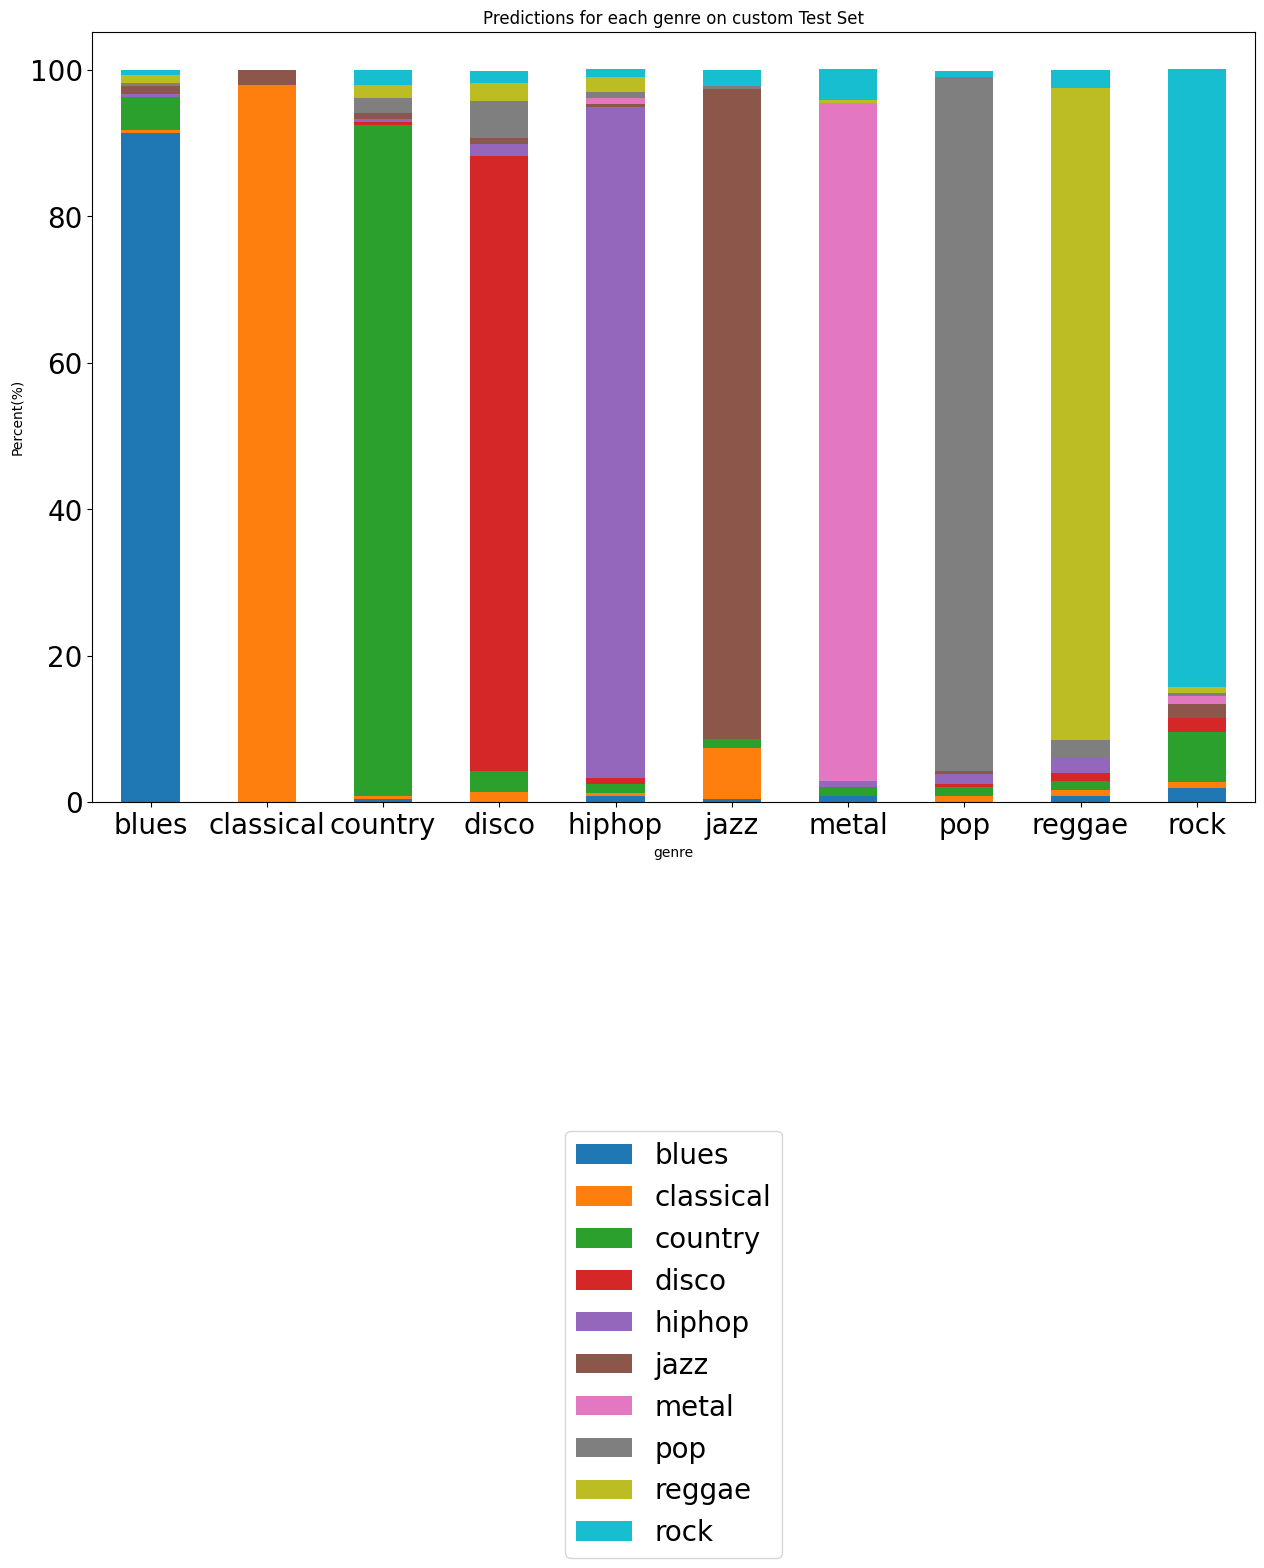

In [18]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = dfc.plot(kind='bar', ylabel='Percent(%)', stacked=True, rot=0, figsize=(15, 10),colormap='tab10', fontsize=20, title='Predictions for each genre on custom Test Set')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1), fontsize=20)
ax.figure.savefig('mfcc_genre_pred.png', dpi=300, pad_inches=0.5, bbox_inches='tight')

In [8]:
test_acc_list

[0.9402985074626866,
 0.9170305676855895,
 0.8778280542986425,
 0.8785425101214575,
 0.9067164179104478,
 0.9067796610169492,
 0.875,
 0.888,
 0.8941176470588236,
 0.691358024691358]

In [1]:
run1 = [0.9267241379310345,
 0.9718875502008032,
 0.8875502008032129,
 0.9405204460966543,
 0.8656716417910447,
 0.8847736625514403,
 0.9279661016949152,
 0.9130434782608695,
 0.8830645161290323,
 0.764]

run2 = [0.9407114624505929,
 0.9512195121951219,
 0.8760683760683761,
 0.7967479674796748,
 0.9609375,
 0.912,
 0.9791666666666666,
 0.8914728682170543,
 0.8538461538461538,
 0.7874015748031497]

run3 = [0.9588477366255144,
 0.9794238683127572,
 0.7984189723320159,
 0.9477911646586346,
 0.8914728682170543,
 0.9108527131782945,
 0.9661016949152542,
 0.9206349206349206,
 0.8376068376068376,
 0.8154981549815498]

run4 = [0.9194139194139194,
 0.9482071713147411,
 0.7992565055762082,
 0.9139784946236559,
 0.8410852713178295,
 0.9327731092436975,
 0.9126637554585153,
 0.95,
 0.9152542372881356,
 0.7991803278688525]

run5 = [0.9402985074626866,
 0.9170305676855895,
 0.8778280542986425,
 0.8785425101214575,
 0.9067164179104478,
 0.9067796610169492,
 0.875,
 0.888,
 0.8941176470588236,
 0.691358024691358]


In [11]:
run_acc_list = np.concatenate((run1, run2, run3, run4, run5), axis=0)
run_acc_list = run_acc_list.reshape(5,10)
run_acc_list

array([[0.92672414, 0.97188755, 0.8875502 , 0.94052045, 0.86567164,
        0.88477366, 0.9279661 , 0.91304348, 0.88306452, 0.764     ],
       [0.94071146, 0.95121951, 0.87606838, 0.79674797, 0.9609375 ,
        0.912     , 0.97916667, 0.89147287, 0.85384615, 0.78740157],
       [0.95884774, 0.97942387, 0.79841897, 0.94779116, 0.89147287,
        0.91085271, 0.96610169, 0.92063492, 0.83760684, 0.81549815],
       [0.91941392, 0.94820717, 0.79925651, 0.91397849, 0.84108527,
        0.93277311, 0.91266376, 0.95      , 0.91525424, 0.79918033],
       [0.94029851, 0.91703057, 0.87782805, 0.87854251, 0.90671642,
        0.90677966, 0.875     , 0.888     , 0.89411765, 0.69135802]])

In [14]:
genre_acc = np.mean(run_acc_list, axis=0)
genre_acc

array([0.93719915, 0.95355373, 0.84782442, 0.89551612, 0.89317674,
       0.90943583, 0.93217964, 0.91263025, 0.87677788, 0.77148762])

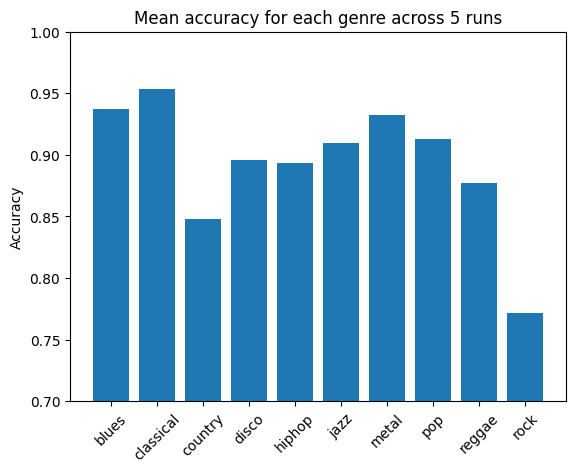

In [16]:
from matplotlib import pyplot as plt
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.bar(genres, genre_acc)
plt.ylim(0.7,1)
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.title('Mean accuracy for each genre across 5 runs')
plt.savefig('mfcc_genre_acc.png', dpi=300)

In [17]:
genre_variances = np.var(run_acc_list, axis=0)
genre_variances

array([0.00018333, 0.00047467, 0.00161516, 0.00302844, 0.00164956,
       0.0002337 , 0.00140532, 0.00050301, 0.00077617, 0.00188678])

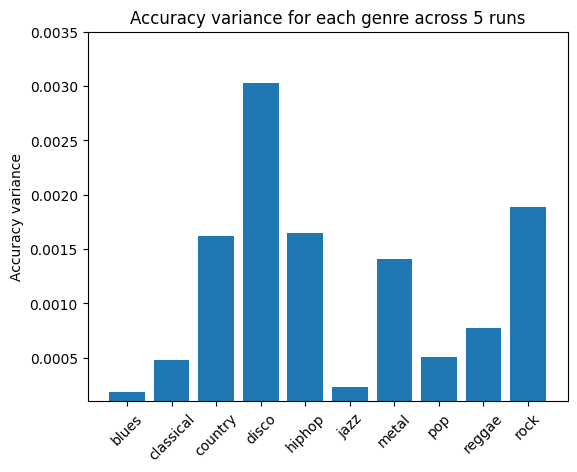

In [20]:
from matplotlib import pyplot as plt
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.bar(genres, genre_variances)
plt.ylim(0.0001,0.0035)
plt.ylabel('Accuracy variance')
plt.xticks(rotation=45)
plt.title('Accuracy variance for each genre across 5 runs')
plt.subplots_adjust(left=0.15)
plt.savefig('mfcc_genre_var.png', dpi=300)

In [21]:
genre_std = np.std(run_acc_list, axis=0)
genre_std

array([0.0135399 , 0.02178701, 0.0401891 , 0.05503123, 0.04061477,
       0.01528718, 0.03748765, 0.02242779, 0.02785984, 0.04343704])

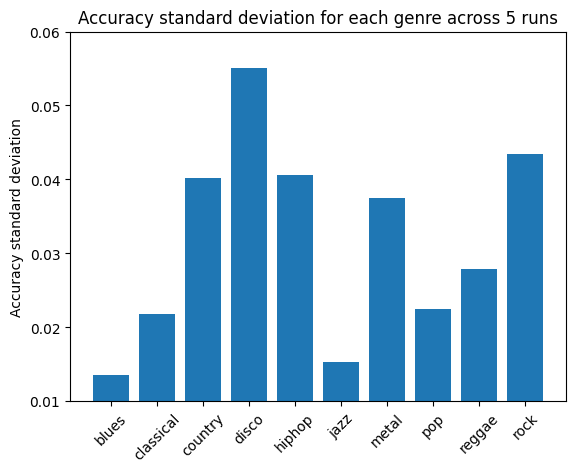

In [27]:
from matplotlib import pyplot as plt
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.bar(genres, genre_std)
plt.ylim(0.01,0.06)
plt.ylabel('Accuracy standard deviation')
plt.xticks(rotation=45)
plt.title('Accuracy standard deviation for each genre across 5 runs')
plt.savefig('mfcc_genre_std.png', dpi=300)

In [28]:
run_acc = np.mean(run_acc_list, axis=1)
run_acc

array([0.89652017, 0.89495721, 0.90266489, 0.89318128, 0.87756714])

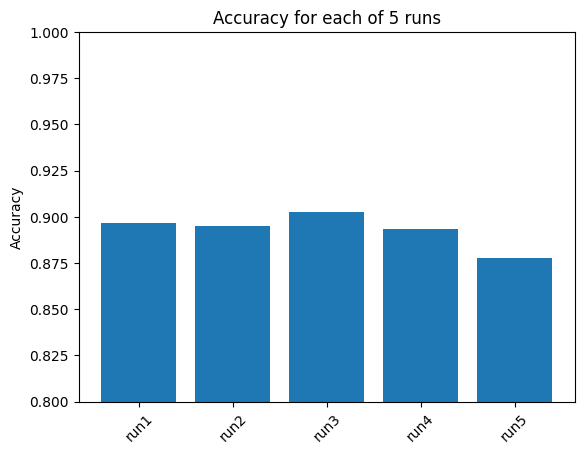

In [29]:
from matplotlib import pyplot as plt
genres = ['run1', 'run2', 'run3', 'run4', 'run5']
plt.bar(genres, run_acc)
plt.ylim(0.8,1)
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.title('Accuracy for each of 5 runs')
plt.savefig('mfcc_runs_acc.png', dpi=300)

In [30]:
run_mean = np.mean(run_acc)
run_mean

0.8929781386200026

In [31]:
run_var = np.var(run_acc)
run_var

6.956722311844032e-05

In [32]:
run_std = np.std(run_acc)
run_std

0.008340696800534132

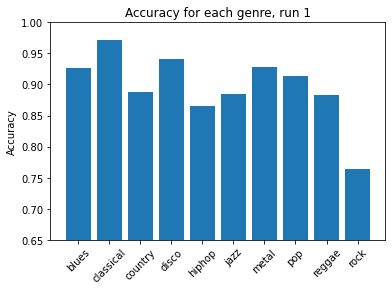

In [2]:
from matplotlib import pyplot as plt
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plt.bar(genres,run1)
plt.ylim(0.65,1)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Accuracy for each genre, run 1')
plt.savefig('mfcc_run1.png', dpi=300)